# Funky Shapes

## !!! Does not work with the normal environment !!!
It requires numpy>=2.0 which is incompatible with the remainder of the installation.

in order to run this, one needs:
- python 
- densired (which will draw numpy and matplotlib)
- tqdm
- pickle

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [4]:
import densired
import numpy as np
# import tqdm
import pickle

In [5]:
skeleton = densired.datagen.densityDataGen(
    dim=8,
    radius=5,
    clunum=6,
    core_num=200,
    min_dist=0.7,
    dens_factors=True,
    step_spread=0.3,
    # ratio_noise=0.1,
    ratio_con=0.01,
)

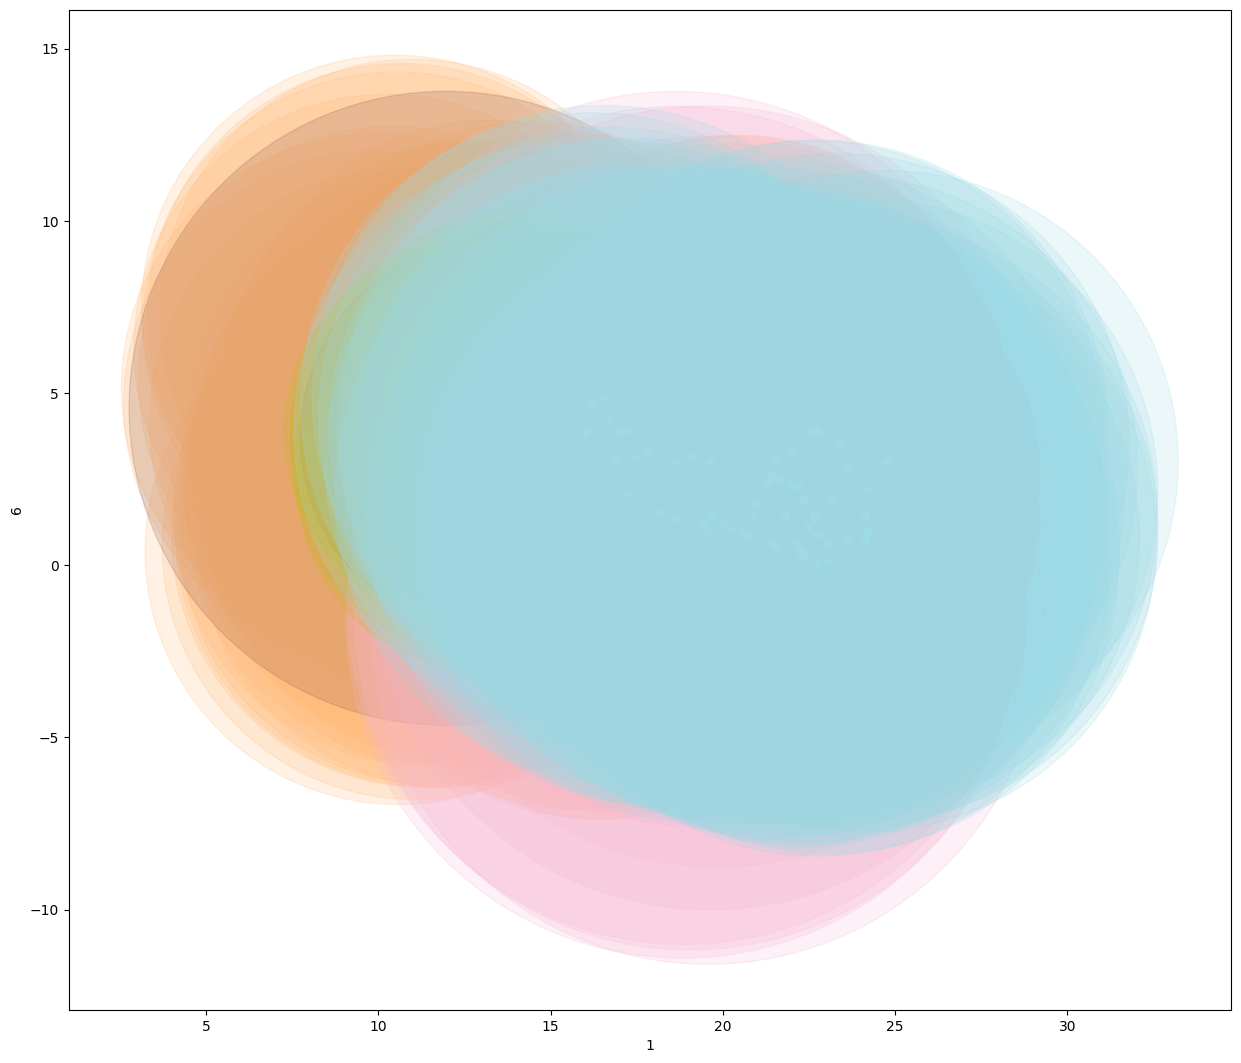

In [6]:
skeleton.display_cores()

In [7]:
data = skeleton.generate_data(data_num=10000)
data[:,-1]

array([0., 0., 0., ..., 4., 2., 2.])

ModuleNotFoundError: No module named 'corc'

In [8]:
np.bincount(np.array(data[:,-1],dtype=int))

array([4209, 1221,   59,  547, 1131, 2833])

In [9]:
funky_shapes = dict()
with open('funky_shapes.npy', 'wb') as f:
    for dim in [8,16,32,64]:
        skeleton = densired.datagen.densityDataGen(
            dim=dim,
            radius=5,
            clunum=6,
            core_num=200,
            min_dist=0.7,
            dens_factors=True,
            step_spread=0.3,
            # ratio_noise=0.1,
            ratio_con=0.01,
        )
        points = skeleton.generate_data(data_num=10000)
        funky_shapes[dim] = points
        
with open('funky_shapes.pkl', 'wb') as f:
    pickle.dump(funky_shapes, f)

with open('funky_shapes.npz', 'wb') as f:
    np.savez(f, d8=funky_shapes[8], d16=funky_shapes[16], d32=funky_shapes[32], d64=funky_shapes[64])

In [35]:
with open('funky_shapes.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)

In [11]:
funky_shapes = dict()
with open('../funky_shapes.npz', 'rb') as f:
    npz_file = np.load(f)
    print(npz_file.files)
    for file in npz_file.files:
        funky_shapes[file] = npz_file[file]

['d8', 'd16', 'd32', 'd64']


In [13]:
funky_shapes['d16'].shape

(10000, 17)

In [1]:
import corc.utils

import torch
import sklearn.model_selection

# constants
noise = True
dim = data.shape[1]-1
classes = int(np.max(data[:,-1]))+1 
if noise:
    classes += 1 # for the noise class


# data loading
X = torch.tensor(data[:,:dim], dtype=torch.float32)
Y = torch.tensor(data[:,-1], dtype=torch.long) 
if noise:
    Y += 1# shift to avoid -1 for the noise points
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# model = torch.nn.Sequential(
#     torch.nn.Linear(dim, 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, classes),
# )

model = torch.nn.Linear(dim, classes)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


ModuleNotFoundError: No module named 'torch'

In [22]:
# model training
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x,y in train_loader:
        y_pred = model(x)
        loss = torch.nn.functional.cross_entropy(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss}')
print('done')

Epoch 1/100, Loss: 105.89410564804078
Epoch 2/100, Loss: 11.284251786231994
Epoch 3/100, Loss: 5.509677130937576
Epoch 4/100, Loss: 3.7453300144672395
Epoch 5/100, Loss: 2.8857780869007112
Epoch 6/100, Loss: 2.3912080216407774
Epoch 7/100, Loss: 2.042907996356487
Epoch 8/100, Loss: 1.781401772737503
Epoch 9/100, Loss: 1.5620567571222783
Epoch 10/100, Loss: 1.3821382905095816
Epoch 11/100, Loss: 1.2176095722615718
Epoch 12/100, Loss: 1.0806215129494667
Epoch 13/100, Loss: 0.9619653740674258
Epoch 14/100, Loss: 0.8607465152740479
Epoch 15/100, Loss: 0.7765681564062834
Epoch 16/100, Loss: 0.6978154877275229
Epoch 17/100, Loss: 0.6373611835241317
Epoch 18/100, Loss: 0.5815453063994646
Epoch 19/100, Loss: 0.5354588404297829
Epoch 20/100, Loss: 0.5025512109994889
Epoch 21/100, Loss: 0.4624458074569702
Epoch 22/100, Loss: 0.4288310478180647
Epoch 23/100, Loss: 0.4024270610436797
Epoch 24/100, Loss: 0.38066316889971497
Epoch 25/100, Loss: 0.35783379547297955
Epoch 26/100, Loss: 0.3391300146207

In [23]:
# check accuracy
model.eval()
total = 0
correct = 0
for x,y in test_loader:
    y_pred = model(x)
    _, y_pred = torch.max(y_pred, 1)
    total += y.size(0)
    correct += (y_pred == y).sum().item()
accuracy = correct / total
print(f'Accuracy: {accuracy}')

Accuracy: 0.999


In [23]:
from scipy.spatial.distance import cdist
cdist(X_train, X_test, metric='euclidean')

NameError: name 'X_train' is not defined